In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import os

In [11]:
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Activation, RepeatVector, Dropout, BatchNormalization, Flatten, Bidirectional, TimeDistributed, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

pd.set_option('display.max_colwidth', 200)

import random
random.seed(0)
import re
import string
import warnings
warnings.filterwarnings("ignore")
from numpy import array, argmax, random, take

nltk.download('stopwords',quiet=True)
nltk.download('wordnet', quiet=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
newscommentary_en_dataset = open('/content/drive/MyDrive/Colab Notebooks/news-commentary-v9_en.txt', encoding='utf-8')
newscommentary_de_dataset = open('/content/drive/MyDrive/Colab Notebooks/news-commentary-v9_de.txt', encoding='utf-8')

In [13]:
newscommentary_en = newscommentary_en_dataset.readlines()
newscommentary_de = newscommentary_de_dataset.readlines()

In [14]:
newscommentary_en_df = pd.DataFrame(newscommentary_en, columns=['English'])
newscommentary_de_df = pd.DataFrame(newscommentary_de, columns = ['German'])

In [15]:
combined_df = pd.concat([newscommentary_de_df, newscommentary_en_df], axis=1)

In [16]:
combined_df.to_csv(r'/content/drive/MyDrive/combined_dataset.csv', index=False)

In [17]:
combined_dataset = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv')

In [18]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201995 entries, 0 to 201994
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   German   201854 non-null  object
 1   English  201995 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [19]:
# Observing the shape of merged dataframes

combined_dataset.shape

(201995, 2)

In [20]:
# Observing the top 5 entries of merged dataframe

combined_dataset.head()

,German,English
0,Steigt Gold auf 10.000 Dollar?\n,"$10,000 Gold?\n"
1,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.\n",SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.\n
2,"In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.\n","Lately, with gold prices up more than 300% over the last decade, it is harder than ever.\n"
3,"Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt a...","Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.\n"
4,"Und es kam, wie es kommen musste.\n",Wouldn’t you know it?\n


In [21]:
# Dropping the null values from the dataframe

combined_dataset.dropna()

,German,English
0,Steigt Gold auf 10.000 Dollar?\n,"$10,000 Gold?\n"
1,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.\n",SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.\n
2,"In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.\n","Lately, with gold prices up more than 300% over the last decade, it is harder than ever.\n"
3,"Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt a...","Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.\n"
4,"Und es kam, wie es kommen musste.\n",Wouldn’t you know it?\n
...,...,...
201849,Das bleibt eine der größten Errungenschaften in der jüngeren Geschichte.\n,It didn’t have to be this way.\n
201850,Gleichzeitig scheint sich Zumas revolutionäre Generation mit der Führung Südafrikas in der nun seit 15 Jahren dauernden Ära nach der Apartheid noch immer unwohl zu fühlen.\n,This past year has seen one missed opportunity after another.\n
201851,"In einer Region, wo die älteren Menschen sehr verehrt werden, muss Zumas Bindung an landestypische Traditionen eine gleichwertige Offenheit gegenüber den Bedürfnissen der Jugend des Landes gegenüb...",South African president Thabo Mbeki convened negotiations with Zimbabwe’s political groups; but they have been so unfruitful that opposition leaders recently all but accused Mbeki of lying to the ...
201852,"Drei von zehn Südafrikanern sind jünger als 15 und das bedeutet, dass sie nicht einen Tag unter der Apartheid gelebt haben.\n","Some African leaders – notably Ghana’s president, John Kufuor, and outgoing African Union head Alpha Konare – have tried to cajole Mugabe towards reform, to no avail.\n"


In [22]:
# Dropping the duplicates from the dataframe

combined_dataset = combined_dataset.drop_duplicates()

In [23]:
# Observing shape of the dataframe after dropping null values and duplicates

combined_dataset.shape

(201936, 2)

In [24]:
# Randomly sample 5% of dataframe

combined_dataset_sample = combined_dataset.sample(frac = 0.005)

In [25]:
# Observing the shape of sampled dataframe

combined_dataset_sample.shape

(1010, 2)

In [27]:
# Adding columns in the dataframe which shows the length of each English and German sentence

combined_dataset_sample['eng_length'] = combined_dataset_sample['English'].str.len()

combined_dataset_sample['ger_length'] = combined_dataset_sample['German'].str.len()

In [28]:
# Observing the information of sampled dataframe

combined_dataset_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010 entries, 66640 to 168471
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   German      1010 non-null   object
 1   English     1010 non-null   object
 2   eng_length  1010 non-null   int64 
 3   ger_length  1010 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 39.5+ KB


In [76]:
combined_dataset_sample = combined_dataset_sample.drop(columns=['eng_length','ger_length'])

In [77]:
combined_dataset_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 159077 to 35254
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   German   51 non-null     object
 1   English  51 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [78]:
# Observing top 5 entries of the sampled dataframe

combined_dataset_sample.head(5)

,German,English
159077,"START_ investoren müssen auf die effektivität von heimischen rechtsinstitutionen zählen können, nicht nur auf die paragraphen im gesetzbuch. _END",The Limits of Energy Innovation
99928,START_ tatsächlich endet mit ihm die gaullistische tradition. _END,Populism Without the People
123566,"START_ es schaudert einem bei dem gedanken an ein parlament, dessen oberstes aufnahmekriterium für abgeordnete die zugehörigkeit zu einer gruppe ist, die durch affirmative action gefördert werden ...","So, what should be done?"
199925,"START_ außerdem befürchtet man, dass islamisten die türkei eines tages in einen fundamentalistischen staat verwandeln könnten. _END",Will Success Spoil Brazil?
141309,"START_ rom reagierte auf diese entwicklung mit der reduktion des gold und silbergehalts der münzen die antike form der monetisierung, was im römischen reich zu anhaltender inflation führte. _END",Their proposal went unheeded.


In [79]:
def clean_sentence(sentence):
    sentence = sentence.lower()  #Convert to lowercase
    sentence = re.sub(r'\s+', ' ', sentence)  # Remove new line character
    sentence = sentence.strip()  # Remove leading and trailing white spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Replace multiple spaces with a single space
    sentence = re.sub(r'[^\w\s.,!?\'"]', '', sentence)  # Remove special characters except common punctuation
    sentence = 'START_ '+ sentence + ' _END'
    return sentence

In [80]:
# Calling process_data function on the sampled dataframe

combined_dataset_sample['German'] = combined_dataset_sample['German'].astype(str).apply(clean_sentence)

In [81]:
combined_dataset_sample['English'] = combined_dataset_sample['English'].astype(str).apply(clean_sentence)

In [82]:
# Observing top 5 entries of the processed dataframe

combined_dataset_sample.head(5)

,German,English
159077,"START_ start_ investoren müssen auf die effektivität von heimischen rechtsinstitutionen zählen können, nicht nur auf die paragraphen im gesetzbuch. _end _END",START_ the limits of energy innovation _END
99928,START_ start_ tatsächlich endet mit ihm die gaullistische tradition. _end _END,START_ populism without the people _END
123566,"START_ start_ es schaudert einem bei dem gedanken an ein parlament, dessen oberstes aufnahmekriterium für abgeordnete die zugehörigkeit zu einer gruppe ist, die durch affirmative action gefördert ...","START_ so, what should be done? _END"
199925,"START_ start_ außerdem befürchtet man, dass islamisten die türkei eines tages in einen fundamentalistischen staat verwandeln könnten. _end _END",START_ will success spoil brazil? _END
141309,"START_ start_ rom reagierte auf diese entwicklung mit der reduktion des gold und silbergehalts der münzen die antike form der monetisierung, was im römischen reich zu anhaltender inflation führte....",START_ their proposal went unheeded. _END


Pre Processing - Dataset suitable to be used for AIML model learning

In [83]:
# Function to generate word tokens
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer()

    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [84]:
# Generate word index

eng_tokenized, eng_tokenizer = tokenize(combined_dataset_sample['English'])
ger_tokenized, ger_tokenizer = tokenize(combined_dataset_sample['German'])

eng_word_index = eng_tokenizer.word_index
ger_word_index = ger_tokenizer.word_index

In [85]:
# Finding the vocabulary size with number of unique tokens

english_vocab = len(eng_tokenizer.word_index) + 1
german_vocab = len(ger_tokenizer.word_index) + 1

print("English vocabulary is of {} unique words".format(english_vocab))
print("german vocabulary is of {} unique words".format(german_vocab))

English vocabulary is of 165 unique words
german vocabulary is of 644 unique words


In [86]:
# Define the parameters

maxlen_eng = int(len(max(eng_tokenized, key=len)))
maxlen_ger = int(len(max(ger_tokenized, key=len)))

print("Maximum Length of English tokens is {}".format(maxlen_eng))
print("Maximum Length of German tokens is {}".format(maxlen_ger))

Maximum Length of English tokens is 7
Maximum Length of German tokens is 71


In [87]:
# Generate token sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
eng_pad_sentence = pad_sequences(eng_tokenized, maxlen_eng, padding = "post")
ger_pad_sentence = pad_sequences(ger_tokenized, maxlen_ger, padding = "post")

print('Number of English Samples are {}:', len(eng_pad_sentence))
print('Number of German Samples are {}:', len(ger_pad_sentence))

Number of English Samples are {}: 51
Number of German Samples are {}: 51


Model Design

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(eng_pad_sentence,ger_pad_sentence,test_size=0.25,shuffle=True,random_state=101)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(38, 7)
(13, 7)
(38, 71)
(13, 71)


In [89]:
combined_dataset_sample = combined_dataset_sample[combined_dataset_sample.English.str.count('\s+').lt(6)]

combined_dataset_sample = combined_dataset_sample.astype(str).applymap(lambda x: str(x.replace('\n','')))

combined_dataset_sample['German'] = combined_dataset_sample['German'].str.strip()

combined_dataset_sample['English'] = combined_dataset_sample['English'].str.strip()

combined_dataset_sample = combined_dataset_sample.replace('', np.nan)

combined_dataset_sample = combined_dataset_sample.dropna()

In [90]:
combined_dataset_sample.count('index')

,0
German,30
English,30


In [91]:
combined_dataset_sample.head(10)

,German,English
99928,START_ start_ tatsächlich endet mit ihm die gaullistische tradition. _end _END,START_ populism without the people _END
199925,"START_ start_ außerdem befürchtet man, dass islamisten die türkei eines tages in einen fundamentalistischen staat verwandeln könnten. _end _END",START_ will success spoil brazil? _END
141309,"START_ start_ rom reagierte auf diese entwicklung mit der reduktion des gold und silbergehalts der münzen die antike form der monetisierung, was im römischen reich zu anhaltender inflation führte....",START_ their proposal went unheeded. _END
71450,START_ start_ amerika muss nun ernsthaft in sich gehen und sein gewissen überprüfen . _end _END,START_ 因此决策者应该加倍努力通过支持可持续包容性经济增长减少贫困他们应高承诺推进可靠的农业管理维系运转良好的市场并增加农业投资与此同时这些紧迫目标也不能妨碍产量这一焦点问题在近几十年中产量增加带来了四分之三的粮食总产增长 _END
86174,"START_ start_ die beinahe gewissheit, dass das repräsentantenhaus und möglicherweise auch der senat in republikanischen händen wären, bedeutet, dass sich der amerikanische kongress auf jeden versu...",START_ century. _END
85539,"START_ start_ im prinzip könne es sein, so heißt es in den klageschriften, dass ein einzelnes land die lasten allein übernehmen muss. _end _END",START_ judging bushu0027s military tribunals _END
185547,"START_ start_ der türkische premier recep tayyip erdogan hat die regionale situation begutachtet und einen verwegenen plan verfasst, um sowohl den regionalen einfluss der türkei als auch seine eig...","START_ typically, hardly anyone noticed. _END"
189733,"START_ start_ während des zweiten weltkriegs war das vergewaltigungsverbot für soldaten im völkerrecht durchaus fest verankert, aber bei den kriegsverbrecherprozessen in nürnberg und tokio kamen n...",START_ war and the environment _END
27628,START_ start_ außerdem bezeichneten die 27 staats und regierungschefs der eu die entscheidung des kremls über die anerkennung der beiden abtrünnigen regionen als inakzeptabel. _end _END,START_ iraq comes first. _END
103346,START_ start_ als folge dessen wird sich der anteil dieser regionen an der weltwirtschaft vergrößern. _end _END,START_ old and aging europe _END


In [92]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/combined_english_german.txt', combined_dataset_sample.to_numpy(), delimiter='\t', fmt='%s')

In [93]:
def load_doc(filename):

    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()

    # close the file
    file.close()

    return text

In [94]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [95]:
from unicodedata import normalize

# Function to clean a list of lines

def clean_pairs(lines):
    cleaned = list()

    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)

    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')

            # tokenize on white space
            line = line.split()

            # convert to lowercase
            line = [word.lower() for word in line]

            # remove punctuation from each token
            line = [word.translate(table) for word in line]

            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]

            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]

            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [96]:
from pickle import load,dump
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [97]:
filename = '/content/drive/MyDrive/Colab Notebooks/combined_english_german.txt'

doc = load_doc(filename)

# Calling to_pair function to split dat into english-german pairs
pairs = to_pairs(doc)

# Calling clean_pair function to clean the sentences
clean_pairs = clean_pairs(pairs)

# Calling save_clean_data function to save clean pairs into file
save_clean_data(clean_pairs, '/content/drive/MyDrive/Colab Notebooks/german-english1.pkl')

Saved: /content/drive/MyDrive/Colab Notebooks/german-english1.pkl


In [98]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [99]:
print(clean_pairs.size)

60


In [100]:
from numpy.random import shuffle

# Loading clean dataset
raw_dataset = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/german-english1.pkl')

# Reducing dataset size
n_sentences = clean_pairs.size
dataset = raw_dataset[:n_sentences, :]

# Randomly shuffling the dataset
shuffle(dataset)

# Generating train and test datasets
train, test = train_test_split(dataset, test_size=0.25, random_state=1)

# Saving clean, train, test dataset into pickle file
save_clean_data(dataset, '/content/drive/MyDrive/Colab Notebooks/english-german-both1.pkl')
save_clean_data(train, '/content/drive/MyDrive/Colab Notebooks/english-german-train1.pkl')
save_clean_data(test, '/content/drive/MyDrive/Colab Notebooks/english-german-test1.pkl')

Saved: /content/drive/MyDrive/Colab Notebooks/english-german-both1.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/english-german-train1.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/english-german-test1.pkl


In [101]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [102]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [103]:
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)

    # padding sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')

    return X

In [104]:
from keras.utils import to_categorical

# Function to convert vectors into binary matrix

def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [105]:
dataset = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-both1.pkl')
train = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-train1.pkl')
test = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-test1.pkl')

In [106]:
eng_tokenizer_rnn = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer_rnn.word_index) + 1
eng_length_rnn = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length_rnn))

# Preparing German tokenizer

ger_tokenizer_rnn = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer_rnn.word_index) + 1
ger_length_rnn = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length_rnn))

English Vocabulary Size: 415
English Max Length: 68
German Vocabulary Size: 87
German Max Length: 6


In [107]:
# prepare training data
trainX = encode_sequences(ger_tokenizer_rnn, ger_length_rnn, train[:, 1])
trainY = encode_sequences(eng_tokenizer_rnn, eng_length_rnn, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer_rnn, ger_length_rnn, test[:, 1])
testY = encode_sequences(eng_tokenizer_rnn, eng_length_rnn, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [108]:
def define_simple_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(SimpleRNN(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(SimpleRNN(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [109]:
model_translate_RNN = define_simple_model(ger_vocab_size, eng_vocab_size, ger_length_rnn, eng_length_rnn, 256)

In [110]:
model_translate_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
model_translate_RNN.build(input_shape=(2))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


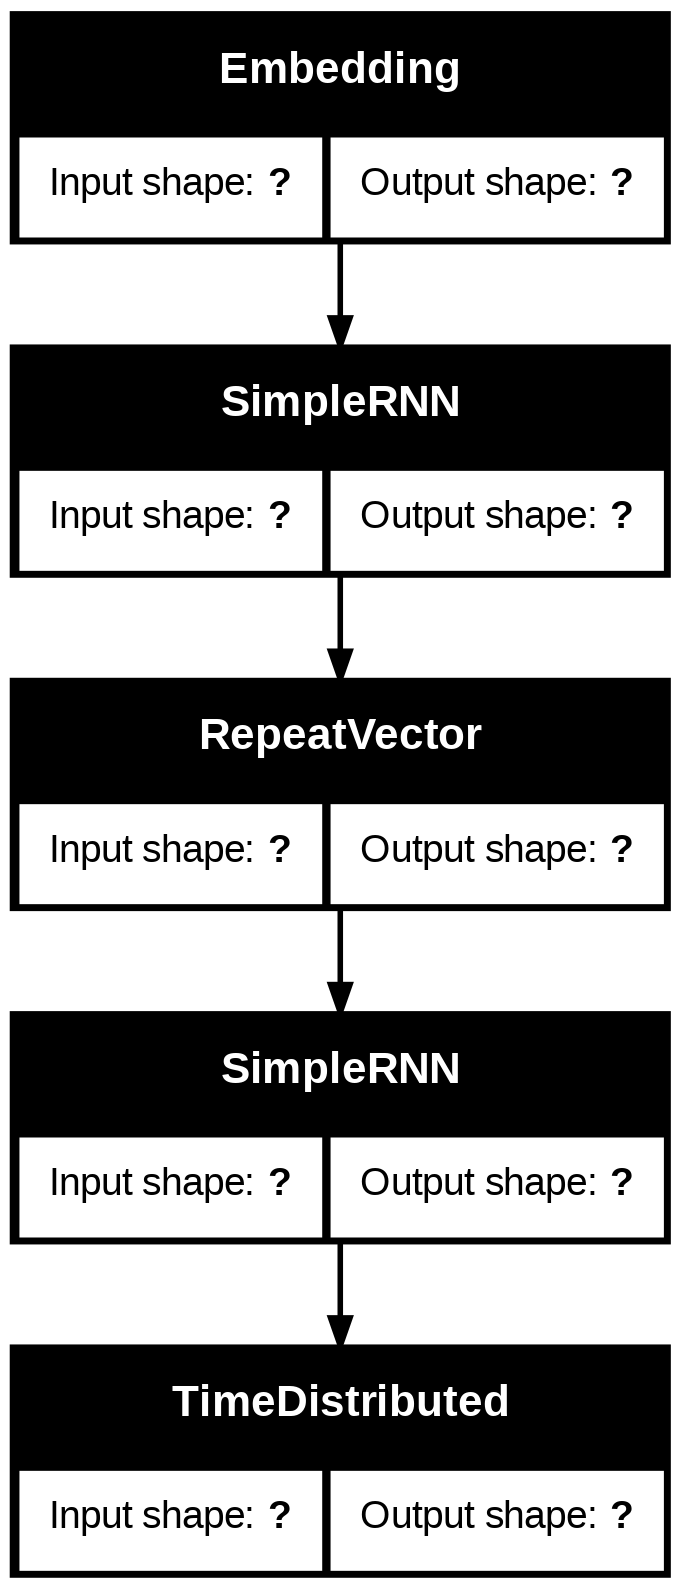

In [112]:
print(model_translate_RNN.summary())

plot_model(model_translate_RNN, to_file='model.png', show_shapes=True)

In [113]:
# Creating the callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/model.keras',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

In [114]:
filename = 'model.h5'

history_1 = model_translate_RNN.fit(trainX, trainY, epochs=30, batch_size=64, validation_split = 0.3, callbacks=[es,rl,mc])

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0020 - loss: 5.9980
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to checkpoint/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0020 - loss: 5.9980 - val_accuracy: 0.7059 - val_loss: 5.3824 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.6167 - loss: 5.4315
Epoch 2: val_accuracy improved from 0.70588 to 0.72689, saving model to checkpoint/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step - accuracy: 0.6167 - loss: 5.4315 - val_accuracy: 0.7269 - val_loss: 4.3835 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.6225 - loss: 4.5531
Epoch 3: val_accuracy did not improve from 0.72689
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.6225 - loss: 4.5531 - val_accuracy: 0.7269 - val_loss: 3.4944 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6225 - loss: 3.8106
Epoch 4: val_ac

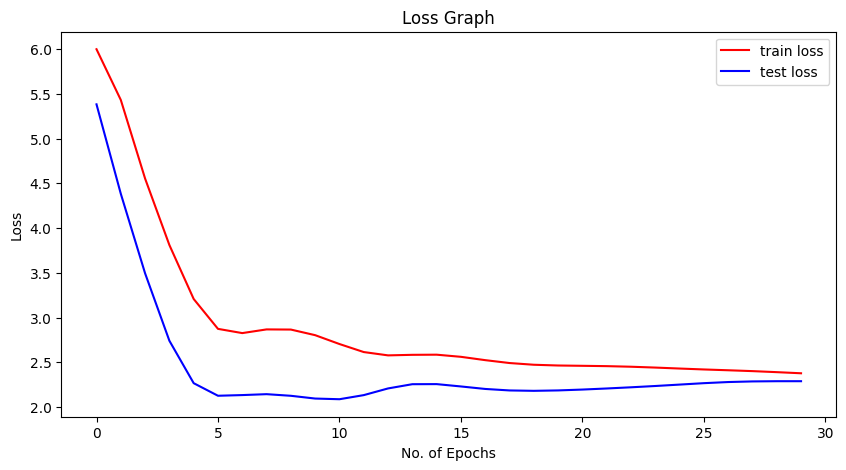

In [115]:
plt.figure(figsize=(10,5))
plt.plot(history_1.history['loss'],'r',label='train loss')
plt.plot(history_1.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

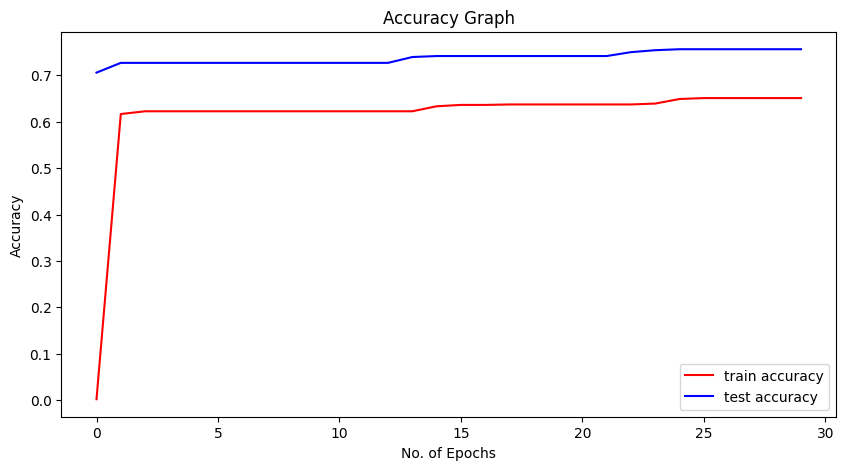

In [116]:
plt.figure(figsize=(10,5))
plt.plot(history_1.history['accuracy'],'r',label='train accuracy')
plt.plot(history_1.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [117]:
results_translate_rnn_test = model_translate_RNN.evaluate(testX, testY)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5919 - loss: 3.8015


In [118]:
results_translate_rnn_train = model_translate_RNN.evaluate(trainX, trainY)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6845 - loss: 2.3420


In [119]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [120]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [121]:
from nltk.translate.bleu_score import corpus_bleu

# Function to evaluate model performance using BLEU score
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):

        # Translating encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer_rnn, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print("The German sentence is:", raw_src)
            print("The English sentence is:", raw_target)
            print("The predicted sentence is:", translation)
            print("*"*50)
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    # Calculating BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [122]:
print('Prediction of training sentences:')
evaluate_model(model_translate_RNN, eng_tokenizer_rnn, trainX, train)

Prediction of training sentences:
The German sentence is: start end
The English sentence is: start start amerika muss nun ernsthaft in sich gehen und sein gewissen uberprufen end end
The predicted sentence is: start
**************************************************
The German sentence is: start a metaphor for obama end
The English sentence is: start start im jahr trat er zuruck um als angela merkels kandidat fur das weitgehend reprasentative amt des deutschen bundesprasidenten zu kandidieren bis zu seinem abrupten rucktritt zeichnete er sich durch kapriziose amtsfuhrung aus end end
The predicted sentence is: start start
**************************************************
The German sentence is: start poverty did not vanish end
The English sentence is: start start es ist damit zu rechnen dass die geleistete arbeitszeit im dritten quartal weiterhin sinken wird end end
The predicted sentence is: start start
**************************************************
The German sentence is: start o